In [2]:
import numpy as np
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from pyds import MassFunction

In [3]:
data_train = pd.read_csv('dataset_for_ex2_N30.txt')
data_test = pd.read_csv('dataset_for_ex2_test.txt')

In [4]:
X_train = data_train[(['x1', 'x2', 'x3'])]
y_train = data_train[(['Y'])]
X_test = data_test[(['x1', 'x2', 'x3'])]
y_test = data_test[(['Y'])]

In [5]:
num_train = X_train.shape[0]
num_test = X_test.shape[0]

In [6]:
gamma1 = 0
gamma2 = 0
gamma3 = 0
Beta = 1
alpha_0 = 0.95

In [7]:
C1 = np.array(data_train[data_train['Y'].isin([1])][{'x1', 'x2'}])
C2 = np.array(data_train[data_train['Y'].isin([2])][{'x1', 'x2'}])
C3 = np.array(data_train[data_train['Y'].isin([3])][{'x1', 'x2'}])
num_mds = C1.shape[0]

In [8]:
def compute_distances(X_test, X_train):
    dists = np.zeros((num_test, num_train))
    M = np.dot(X_test, X_train.T)
    te = np.square(X_test).sum(axis=1)
    tr = np.square(X_train).sum(axis=1)
    dists = np.sqrt(-2 * M + np.matrix(tr) + np.matrix(te).T)
    return dists

In [9]:
def compute_mean_distances(C):
    dists = np.zeros((num_mds, num_mds))
    M = np.dot(C, C.T)
    tr = np.square(C).sum(axis=1)
    dists = np.sqrt(np.abs(-2 * M + 2 * np.matrix(tr)))
    ds = (np.sum(dists) - np.sum(tr)) / (num_mds ** 2 - num_mds)
    return ds

In [10]:
def phi1(d_s):
    return np.exp(- gamma1 * (d_s ** Beta))

In [11]:
def phi2(d_s):
    return np.exp(- gamma2 * (d_s ** Beta))

In [12]:
def phi3(d_s):
    return np.exp(- gamma3 * (d_s ** Beta))

In [13]:
def predict_labels(y_train, dists, k):
    y_pred = np.zeros(num_test)
    for i in range(num_test):
        labels = np.matrix(y_train)[np.argsort(dists[i, :])].flatten()
        closest_y = labels[0, 0:k]
        l_c_y = closest_y.tolist()[0]
        c = Counter(l_c_y)
        y_pred[i] = c.most_common(1)[0][0]
    return y_pred

In [14]:
def predict_labels_weight(y_train, dists, k):
    y_pred = np.zeros(num_test)
    for i in range(num_test):
        closest_y = []
        distances = np.sort(np.matrix(dists)).flatten()[:, 0:k]
        dk = distances[:, k - 1]
        d1 = distances[:, 0]
        delta_d = dk - d1
        ds = (dk - distances) / delta_d
        labels = np.matrix(y_train)[np.argsort(dists[i, :])].flatten()
        closest_y = labels[0, 0:k]
        weights = np.zeros(3)
        for j in range(k):
            if closest_y.tolist()[0][j] == 1:
                weights[0] += ds.tolist()[0][j]
            elif closest_y.tolist()[0][j] == 2:
                weights[1] += ds.tolist()[0][j]
            else:
                weights[2] += ds.tolist()[0][j]
        if weights[0] > weights[1] and weights[0] > weights[2]:
            y_pred[i] = 1
        elif weights[1] > weights[0] and weights[1] > weights[2]:
            y_pred[i] = 2
        else:
            y_pred[i] = 3
    return y_pred

In [15]:
def predict_labels_DS(y_train, dists, k):
    y_pred = np.zeros(num_test)
    for i in range(num_test):
        closest_y = []
        distances = np.sort(np.matrix(dists)).flatten()[:, 0:k]
        labels = np.matrix(y_train)[np.argsort(dists[i, :])].flatten()
        closest_y = labels[0, 0:k]
        weights = np.zeros([3, k])
        count1 = 0
        count2 = 0
        count3 = 0
        for j in range(k):
            if closest_y.tolist()[0][j] == 1:
                count1 += 1
                weights[0][j] = distances.tolist()[0][j]
            elif closest_y.tolist()[0][j] == 2:
                count2 += 1
                weights[1][j] = distances.tolist()[0][j]
            else:
                count3 += 1
                weights[2][j] = distances.tolist()[0][j]
        m1 = [1, 0, 0, 0]
        m2 = [0, 1, 0, 0]
        m3 = [0, 0, 1, 0]
        for l in range(k):
            if weights[0][l] != 0:
                m1[0] *= 1 - alpha_0 * phi1(weights[0][l])
            if weights[1][l] != 0:
                m2[1] *= 1 - alpha_0 * phi2(weights[1][l])
            if weights[2][l] != 0:
                m3[2] *= 1 - alpha_0 * phi3(weights[2][l])

        M1 = MassFunction({'1': 1 - m1[0], '2': 0, '3': 0, '123': m1[0]})
        M2 = MassFunction({'1': 0, '2': 1 - m2[1], '3': 0, '123': m2[1]})
        M3 = MassFunction({'1': 0, '2': 0, '3': 1 - m3[2], '123': m3[2]})

        if count1 == 0 and count2 == 0:
            M = M3
        elif count1 == 0 and count3 == 0:
            M = M2
        elif count2 == 0 and count3 == 0:
            M = M1
        else:
            M = M1 & M2 & M3

        max_bel = max(M.bel({'1'}), M.bel({'2'}), M.bel({'3'}))
        max_pl = max(M.pl({'1'}), M.pl({'2'}), M.pl({'3'}))
        if (M.bel({'1'}) == max_bel):
            y_pred[i] = 1
        if (M.bel({'2'}) == max_bel):
            y_pred[i] = 2
        if (M.bel({'3'}) == max_bel):
            y_pred[i] = 3
    return y_pred

In [16]:
k_to_error = {}
k_to_error_w = {}
k_to_error_d = {}
k_choices = list(range(2, 26))

In [17]:
dq1 = compute_mean_distances(C1)
dq2 = compute_mean_distances(C2)
dq3 = compute_mean_distances(C3)
gamma1 = 1 / dq1
gamma2 = 1 / dq2
gamma3 = 1 / dq3

In [18]:
for k in k_choices:
    distances = compute_distances(X_test, X_train)

    pred = predict_labels(y_train, distances, k)
    pred = pred.reshape((-1, 1))
    num_correct = np.sum(pred == y_test)
    error_rate = float(1 - (num_correct / num_test))

    pred = predict_labels_weight(y_train, distances, k)
    pred = pred.reshape((-1, 1))
    num_correct = np.sum(pred == y_test)
    error_rate_w = float(1 - (num_correct / num_test))

    pred = predict_labels_DS(y_train, distances, k)
    pred = pred.reshape((-1, 1))
    num_correct = np.sum(pred == y_test)
    error_rate_d = float(1 - (num_correct / num_test))

    k_to_error[k] = k_to_error.get(k, []) + [error_rate]
    k_to_error_w[k] = k_to_error_w.get(k, []) + [error_rate_w]
    k_to_error_d[k] = k_to_error_d.get(k, []) + [error_rate_d]

In [19]:
avg_error_rate = 0
avg_error_rate_w = 0
avg_error_rate_d = 0

In [20]:
min_error_rate = 1
min_error_rate_w = 1
min_error_rate_d = 1

In [21]:
k_min = 2
k_min_w = 2
k_min_d = 2

In [22]:
k_error_rate = []
k_error_rate_w = []
k_error_rate_d = []

In [23]:
for key, value in k_to_error.items():
    if value[0] < min_error_rate:
        min_error_rate = value[0]
        k_min = key
    avg_error_rate += value[0]
    k_error_rate.append(value[0])

In [24]:
for key, value in k_to_error_w.items():
    if value[0] < min_error_rate_w:
        min_error_rate_w = value[0]
        k_min_w = key
    avg_error_rate_w += value[0]
    k_error_rate_w.append(value[0])

In [25]:
for key, value in k_to_error_d.items():
    if value[0] < min_error_rate_d:
        min_error_rate_d = value[0]
        k_min_d = key
    avg_error_rate_d += value[0]
    k_error_rate_d.append(value[0])

In [26]:
print('average error rate for kNN :', avg_error_rate / 24)
print('average error rate for weighted_kNN :', avg_error_rate_w / 24)
print('average error rate for DS_kNN :', avg_error_rate_d / 24)

average error rate for kNN : 0.3845929262595929
average error rate for weighted_kNN : 0.35618952285618954
average error rate for DS_kNN : 0.3052218885552219


In [27]:
print('k = %d, min error rate for kNN: %.3f' % (k_min, min_error_rate))
print('k = %d, min error rate for weighted-kNN: %.3f' % (k_min_w, min_error_rate_w))
print('k = %d, min error rate for DS-kNN: %.3f' % (k_min_d, min_error_rate_d))

k = 5, min error rate for kNN: 0.327
k = 9, min error rate for weighted-kNN: 0.326
k = 19, min error rate for DS-kNN: 0.284


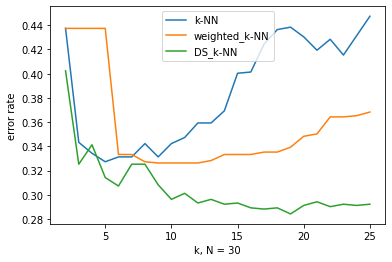

In [28]:
plt.xlabel('k, N = 30')
plt.ylabel('error rate')
plt.plot(k_choices, k_error_rate)
plt.plot(k_choices, k_error_rate_w)
plt.plot(k_choices, k_error_rate_d)
plt.legend(['k-NN', 'weighted_k-NN', 'DS_k-NN'])
plt.show()